<a href="https://colab.research.google.com/github/paranjaa/ece1508-student-depression-project/blob/main/ECE1508_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ECE 1508 Final Project ##
### Training MLPs to recognize Depression ###

### Imports

In [15]:
#import each one of the libraries
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

Import dataset either from file upload (at https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

(Or from google drive, seems like upload doesn't work off a tablet)

In [16]:

from google.colab import files
uploaded = files.upload()
df = pd.read_csv("Student Depression Dataset.csv")

# from google.colab import drive
# drive.mount("/content/gdrive")
# df = pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")

# df.info()
# # df.head()

Saving Student Depression Dataset.csv to Student Depression Dataset (2).csv


### Dataset cleanup

Make a copy of the dataframe for cleanup (might want to do different things, so keep the original imported one)
Going through it one column at a time w/ notes

In [17]:
df_1 = df.copy()


In [18]:
# id: not sure why its numbered like that, probably not useful
#dropping it for now, might need it later
df_1 = df_1.drop('id', axis=1)

In [21]:

## Gender: convert to one hot columns? maybe useful. Gender ratio is at 0.44, not so bad
# df["Gender"].value_counts()
df_1["Gender"] = df_1["Gender"].map({"Female": 1, "Male": 0})
df_1["Gender"] = df_1["Gender"].astype(bool)



In [22]:
## Age: convert from float to int, no decimals. Mostly in 20s, maybe find an average
# df_1["Age"].value_counts()

df_1["Age"] = df_1["Age"].astype(int)


In [23]:
# # City: convert to one hot columns. Put the couple dozen cities with one or two students in "other"
# # df_1["City"].value_counts()

# city_count = df_1["City"].value_counts()

# #getting cities that are in less than 10 data points
# threshold = 10
# rare_cities = city_count[city_count < threshold].index

# #replace the values in City where there's something in the rare cities list with other
# #got this partially from gpt, verify how it works
# df_1["City"] = df_1["City"].where(~df_1["City"].isin(rare_cities), "Other")
# city_count = df_1["City"].value_counts()
# # df_1["City"].value_counts()

# #get a data frame of one-hot columns of the cities
# cities_df = pd.get_dummies(df_1["City"], prefix="city")
# # cities_df_1.head()

# #then add it onto the side of the original dataframe
# df_1 = pd.concat([df_1, cities_df_1], axis=1)
# #remove the original cities column

# Actually, maybe too many cities to really help w/ one hot columns, disregarding it for now

df_1 = df_1.drop('City', axis=1)

In [24]:
## Profession: not useful, barely anyone put anything other than "student"
# df_1["Profession"].value_counts()
#also dropping this one
df_1 = df_1.drop('Profession', axis=1)

In [25]:
## Academic Pressure: convert to int. 3 is most popular, followed by 5, then 4.
# df_1["Academic Pressure"].value_counts()
df_1 = df_1.rename(columns={'Academic Pressure': 'Academic Pressure'})
df_1["Academic Pressure"] = df_1["Academic Pressure"].astype(int)

In [26]:
# Work Pressure: Not useful. Only 3 people put anything other than 0
# df_1["Work Pressure"].value_counts()
df_1 = df_1.drop('Work Pressure', axis=1)

In [27]:
## CGPA: Need to keep this as a float? There's 322 distinct values, but it seems useful.
## maybe separate it into brackets though
# df_1["CGPA"].value_counts()

#not touching this one for now, just putting it in lowercase
# df_1 = df_1.rename(columns={'CGPA': 'cgpa'})


In [28]:
# Study Satisfaction: Convert to int. Suprisingly close values, save for people who put 0.0
# df_1["Study Satisfaction"].value_counts()

# dfdf_1 = df_1.rename(columns={'Study Satisfaction': 'Study Satisfaction'})
df_1["Study Satisfaction"] = df_1["Study Satisfaction"].astype(int)


In [29]:
# Job Satisfaction: Not useful, assuming that 0.0 means N.A, and so many people put student
# df_1["Job Satisfaction"].value_counts()

df_1 = df_1.drop('Job Satisfaction', axis=1)

In [30]:

## Sleep Duration: Convert to numeric values and one hot columns?
## it's in a weird format with things in buckets
# df["Sleep Duration"].value_counts()

#making one hot columns for these
sleep_df = pd.get_dummies(df_1['Sleep Duration'], prefix='sleep')
#adding them back onto the side, removing original
df_1 = pd.concat([df_1, sleep_df], axis=1)
#figure out some way to name them better later on

df_1 = df_1.drop('Sleep Duration', axis=1)

In [31]:
# Dietary Habits: Need one hot columns. "Unhealthy" is most popular, but only by <500
# df_1["Dietary Habits"].value_counts()
diet_df = pd.get_dummies(df_1['Dietary Habits'], prefix='diet')
df_1 = pd.concat([df_1, diet_df], axis=1)
df_1 = df_1.drop('Dietary Habits', axis=1)


In [32]:
## Degree: Lots of categories. Put into one hot columns? It'll make a lot of them
# df_1["Degree"].value_counts()
# changing this to gather up each term into larger categories than just one hot columns
# degree_df = pd.get_dummies(df_1['Degree'], prefix='degree')
# df_1 = pd.concat([df_1, degree_df_1], axis=1)
df_1 = df_1.drop('Degree', axis=1)


In [33]:
## Have you ever had suicidal thoughts ? : Convert to binary. Almost 60% say yes, which I guess could be worse
## Also rename to something more concise than all that

# df_1["Have you ever had suicidal thoughts ?"].value_counts()
# df_1 = df_1.rename(columns={'Have you ever had suicidal thoughts ?': 'suicidal_thoughts'})
df_1["Have you ever had suicidal thoughts ?"] = df_1["Have you ever had suicidal thoughts ?"].map({"Yes": True, "No": False})


In [34]:
## Work/Study Hours: Most people are in the range of 10-12 hours. Convert to int.
# df_1["Work/Study Hours"].value_counts()
# df_1 = df_1.rename(columns={'Work/Study Hours': 'work_study_hours'})
df_1["Work/Study Hours"] = df_1["Work/Study Hours"].astype(int)

In [35]:
# Financial Stress: Suprisngly close, with 5.0 on top. Convert to int.
# df = df.rename(columns={'Financial Stress': 'financial_stress'})
df_1["Financial Stress"].value_counts()
#wait, this column has two values that aren't filled in, it has 27898 entries?
#filling the handful of NA values with a 5, since it's already ahead by 900 or so
df_1["Financial Stress"] = df_1["Financial Stress"].fillna(5.0)

df_1["Financial Stress"] = df_1["Financial Stress"].astype(int)

In [36]:
# Family History of Mental Illness: Also quite close numbers, convert to binary
#also rename this one
# df_1["Family History of Mental Illness"].value_counts()

# df_1 = df_1.rename(columns={"Family History of Mental Illness": "family_history"})
df_1["Family History of Mental Illness"] = df_1["Family History of Mental Illness"].map({"Yes": True, "No": False})

In [37]:
# Depression: Main label. More people do than don't.
# df_1["Depression"].value_counts()

# df_1 = df_1.rename(columns={"Depression": "depression"})
df_1["Depression"] = df_1["Depression"].astype(bool)

#put depression at the end of the list so we can get at it easily
final_column = df_1.pop('Depression')
df_1['Depression'] = final_column


In [38]:
#final name cleanup, put everything else in lowercase, as well as replacing any spaces
# df.columns = df.columns.str.lower()
# df.columns = df.columns.str.replace(" ", "_")
# df.columns = df.columns.str.replace("-", "_")

In [39]:
df.info()
# df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

## Correlation (WIP) ###

In [14]:
# Moving all these into one section, might want to put them with the cleanup after
# also need to fix what version of the df they're looking at

# correlation_df = pd.read_csv("gdrive/My Drive/ECE1508/Project/Student_Depression_Dataset.csv")
# # normalize age, too

# pd.crosstab(correlation_df['Gender'], correlation_df['Depression'])

# #difficult to see from how it's mapped, but
# # similar rates of depression, about 70% have it, with men being slightly higher

# pd.crosstab(correlation_df['work_study_hours'], correlation_df['depression'])
# pd.crosstab(correlation_df['financial_stress'], correlation_df['depression'])
# pd.crosstab(correlation_df['family_history'], correlation_df['depression'])
# #more evenly matched than expected. A family history didn't add that much to the chances of having depression
# pd.crosstab(correlation_df['sleep'], correlation_df['depression'])
# pd.crosstab(correlation_df['suicidal_thoughts'], correlation_df['depression'])
# #not a suprise, most people w/ suidical thoughts are also depressed
# pd.crosstab(correlation_df['Study Satisfaction'], correlation_df['Depression'])
# # Not as stratified as expected. Lower satisfaction means more depression
# # Not as much as academic pressure, not nearly 1/6th difference
# # pd.crosstab(df['cgpa'], df['depression'])
# pd.crosstab(correlation_df['Academic Pressure'], correlation_df['Depression'])
# #as expected, higher academic pressure means higher chances of prediction


SyntaxError: incomplete input (<ipython-input-14-596e9429734a>, line 25)

## Evaluation Function (works, but WIP) ##
Split this up into pieces?

In [69]:
def evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):

    train_loss_tracker = []
    test_loss_tracker = []

    # adding this to also graph the accuracy in here
    train_accuracy_tracker = []
    test_accuracy_tracker = []

    for epoch in range(num_epochs):

        # set the model to train and put the accumulators to zero
        model.train()


        total_train_loss = 0.0
        train_correct = 0
        train_total = 0

        #do training loop
        for X_batch, y_batch in train_loader:

            X_batch = X_batch.to(device)
            y_batch.to(device)

            # do the forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_train_loss += loss.item()

            # do the  pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get training accuracy as well
            # starting w/ predicted class


            train_predicted = (outputs > 0.5).float()
            train_correct += (train_predicted == y_batch).sum().item()
            train_total += y_batch.size(0)





        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_tracker.append(avg_train_loss)

        train_accuracy = 100 * train_correct / train_total
        train_accuracy_tracker.append(train_accuracy)


        #do the test function afterwards

        model.eval()

        total_test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
           for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)


                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_test_loss += loss.item()


                # get accuracy for test as well
                test_predicted = (outputs > 0.5).float()
                test_correct += (test_predicted == y_batch).sum().item()
                test_total += y_batch.size(0)




        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_loss_tracker.append(avg_test_loss)
        test_accuracy_tracker.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


    # Adding this from other doc to do both graphs at once



    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot( range(1, num_epochs + 1), train_loss_tracker, label='Training Loss', color='blue')
    plt.plot( range(1, num_epochs + 1), test_loss_tracker, label='Testing Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot( range(1, num_epochs + 1), train_accuracy_tracker, label='Training Accuracy', color='blue')
    plt.plot( range(1, num_epochs + 1), test_accuracy_tracker, label='Test Accuracy', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



    plt.tight_layout()
    plt.show()


# Simple Neural Network 1

Starting off w/ a simple neural network, looking at the columns

In [40]:
X = df_1.iloc[:, 0:-1].values # get everything except for the last column, done the cleanup
y = df_1.iloc[:, -1].values   # only take the last one, since it has our label

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#some weird conversion with going to numpy arrays
X_train = torch.tensor(X_train.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))


#similar kind of reshaping for binary classification
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [42]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 50

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [44]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        #doing it this way instead
        self.model = nn.Sequential(
            nn.Linear(18, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()

            # Put some dropout

            # nn.Linear(46, 64),
            # nn.ReLU(),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            # nn.Linear(32, 16),
            # nn.ReLU(),
            # nn.Linear(8, 4),
            # nn.ReLU(),
            # nn.Linear(4, 2),
            # nn.ReLU(),
            # nn.Linear(2, 1),
            # nn.Sigmoid()
        )


    def forward(self, x):
      return self.model(x)

In [66]:
def evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs):

    train_loss_tracker = []
    test_loss_tracker = []

    # adding this to also graph the accuracy in here
    train_accuracy_tracker = []
    test_accuracy_tracker = []

    for epoch in range(num_epochs):

        # set the model to train and put the accumulators to zero
        model.train()


        total_train_loss = 0.0
        train_correct = 0
        train_total = 0

        #do training loop
        for X_batch, y_batch in train_loader:

            X_batch = X_batch.to(device)
            y_batch.to(device)

            # do the forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_train_loss += loss.item()

            # do the  pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get training accuracy as well
            # starting w/ predicted class


            train_predicted = (outputs > 0.5).float()
            train_correct += (train_predicted == y_batch).sum().item()
            train_total += y_batch.size(0)





        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_tracker.append(avg_train_loss)

        train_accuracy = 100 * train_correct / train_total
        train_accuracy_tracker.append(train_accuracy)


        #do the test function afterwards

        model.eval()

        total_test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
           for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)


                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                total_test_loss += loss.item()


                # get accuracy for test as well
                test_total += y_batch.size(0)
                test_predicted = (outputs > 0.5).float()
                test_correct += (test_predicted == y_batch).sum().item()




        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        test_loss_tracker.append(avg_test_loss)
        test_accuracy_tracker.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
              f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


    # Adding this from other doc to do both graphs at once



    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot( range(1, num_epochs + 1), train_loss_tracker, label='Training Loss', color='blue')
    plt.plot( range(1, num_epochs + 1), test_loss_tracker, label='Testing Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot( range(1, num_epochs + 1), train_accuracy_tracker, label='Training Accuracy', color='blue')
    plt.plot( range(1, num_epochs + 1), test_accuracy_tracker, label='Testing Accuracy', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



    plt.tight_layout()
    plt.show()


Epoch [1/5] - Train Loss: 0.4653, Train Acc: 77.42% - Test Loss: 0.3816, Test Acc: 82.83%
Epoch [2/5] - Train Loss: 0.3586, Train Acc: 84.58% - Test Loss: 0.3886, Test Acc: 82.49%
Epoch [3/5] - Train Loss: 0.3552, Train Acc: 84.55% - Test Loss: 0.3680, Test Acc: 83.61%
Epoch [4/5] - Train Loss: 0.3540, Train Acc: 84.60% - Test Loss: 0.3692, Test Acc: 83.80%
Epoch [5/5] - Train Loss: 0.3521, Train Acc: 84.79% - Test Loss: 0.3724, Test Acc: 83.89%


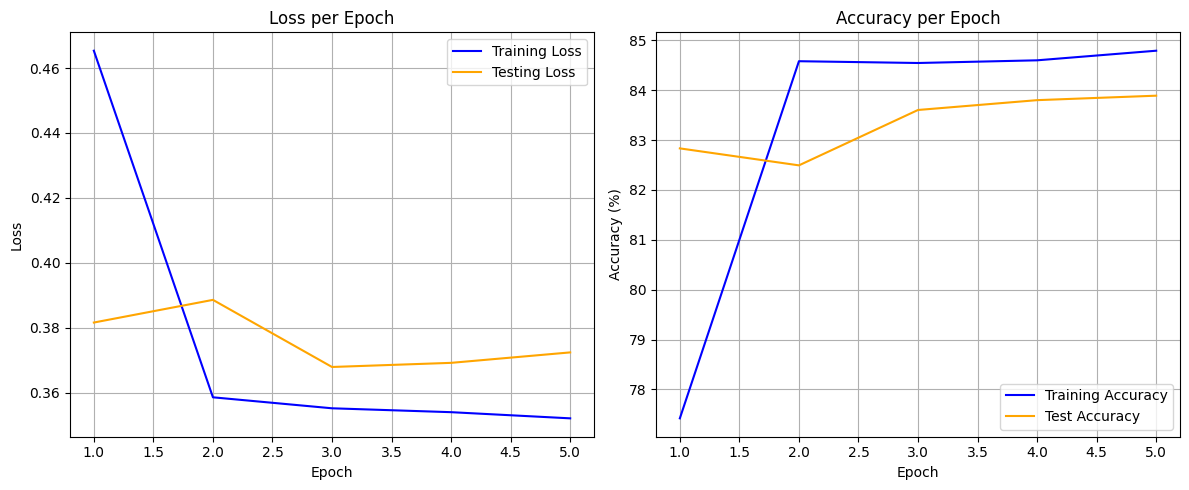

<Figure size 640x480 with 0 Axes>

In [67]:
model = SimpleNN()
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

evaluate(model, train_loader, test_loader, loss_function, optimizer, num_epochs)

In [ ]:
# Suggestions
#precision recall, f1 score to improve loss

In [ ]:
# Going to try and get llama or deepseek running in here to answer prompts

### LLM testing (Llama 3.2) ###

In [ ]:
# Let's try that again
# trying based on this notebook:
# https://colab.research.google.com/github/5aharsh/collama/blob/main/Ollama_Setup.ipynb#scrollTo=Jh5CBAFxBYAC

In [ ]:
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,381 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,688 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jamm

In [ ]:
import threading
import subprocess
import time

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

In [ ]:
!ollama pull llama3.2

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠧ pulling manifest ⠧ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 839 KB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   2% ▕▏  37 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   3% ▕▏  61 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   6% ▕▏ 112 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   7% ▕▏ 141 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   8% ▕▏ 154 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   9% ▕▏ 184 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...  10% ▕▏ 199 MB/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff

In [ ]:
!pip install langchain-ollama

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from IPython.display import Markdown

template = """Question: {question}

Answer: Let's think step by step."""

prompt = ChatPromptTemplate.from_template(template)

model = OllamaLLM(model="llama3.2")

chain = prompt | model

display(Markdown(chain.invoke({"question": "What's the length of hypotenuse in a right angled triangle"})))

To find the length of the hypotenuse (the side opposite the right angle) in a right-angled triangle, we can use the Pythagorean theorem.

The Pythagorean theorem states that in a right-angled triangle, the square of the length of the hypotenuse (c) is equal to the sum of the squares of the lengths of the other two sides (a and b). Mathematically, this is expressed as:

c² = a² + b²

To find the length of the hypotenuse (c), we need to rearrange the equation to isolate c. This gives us:

c = √(a² + b²)

Where √ represents the square root.

For example, if one side (let's say 'a') is 3 units long and the other side ('b') is 4 units long, we can plug these values into the equation to find the length of the hypotenuse:

c = √(3² + 4²)
= √(9 + 16)
= √25
= 5

So, in this example, the length of the hypotenuse (the side opposite the right angle) is 5 units long.

In [ ]:
display(Markdown(chain.invoke({"question": "You are a mental health prediction model. Given the following student's data, your job is to classify them as either 1 for depressed or 0 for not depressed."})))

I'd be happy to help you with this problem. However, I don't see any student's data provided. Please provide the data, and I'll guide you through the process of classifying them as either "depressed" (1) or "not depressed" (0). What type of data is it (e.g., demographics, symptoms, test scores)?

In [ ]:
question_1 = f"""
    Here is the information from particular student:
    - Gender: {df['Gender'].iloc[0]}
    - Age: {df['Age'].iloc[0]}
    - City: {df['City'].iloc[0]}
    - Profession: {df['Profession'].iloc[0]}
    - Academic Pressure: {df['Academic Pressure'].iloc[0]}
    - Work Pressure: {df['Work Pressure'].iloc[0]}
    - CGPA: {df['CGPA'].iloc[0]}
    - Study Satisfaction: {df['Study Satisfaction'].iloc[0]}
    - Job Satisfaction: {df['Job Satisfaction'].iloc[0]}
    - Sleep Duration: {df['Sleep Duration'].iloc[0]}
    - Dietary Habits: {df['Dietary Habits'].iloc[0]}
    - Degree: {df['Degree'].iloc[0]}
    - Have they had suicidal thoughts before? {df['Have you ever had suicidal thoughts ?'].iloc[0]}
    - Work/Study Hours: {df['Work/Study Hours'].iloc[0]}
    - Financial Stress: {df['Financial Stress'].iloc[0]}
    - Family history of mental illness: {df['Family History of Mental Illness'].iloc[0]}
    Please Respond with only one word: either 1 or 0.
    """

In [ ]:
print(question_1)


    Here is the information from particular student:
    - Gender: Male
    - Age: 33.0
    - City: Visakhapatnam
    - Profession: Student
    - Academic Pressure: 5.0
    - Work Pressure: 0.0
    - CGPA: 8.97
    - Study Satisfaction: 2.0
    - Job Satisfaction: 0.0
    - Sleep Duration: 5-6 hours
    - Dietary Habits: Healthy
    - Degree: B.Pharm
    - Have they had suicidal thoughts before? Yes
    - Work/Study Hours: 3.0
    - Financial Stress: 1.0
    - Family history of mental illness: No
    Please Respond with only one word: either 1 or 0.
    


In [ ]:
display(Markdown(chain.invoke({question_1})))

Based on the provided information, I would respond with:

0

In [ ]:
question_2 = f"""
    Here is the information from another student:
    - Gender: {df['Gender'].iloc[1]}
    - Age: {df['Age'].iloc[1]}
    - City: {df['City'].iloc[1]}
    - Profession: {df['Profession'].iloc[1]}
    - Academic Pressure: {df['Academic Pressure'].iloc[1]}
    - Work Pressure: {df['Work Pressure'].iloc[1]}
    - CGPA: {df['CGPA'].iloc[1]}
    - Study Satisfaction: {df['Study Satisfaction'].iloc[1]}
    - Job Satisfaction: {df['Job Satisfaction'].iloc[1]}
    - Sleep Duration: {df['Sleep Duration'].iloc[1]}
    - Dietary Habits: {df['Dietary Habits'].iloc[1]}
    - Degree: {df['Degree'].iloc[1]}
    - Have they had suicidal thoughts before? {df['Have you ever had suicidal thoughts ?'].iloc[1]}
    - Work/Study Hours: {df['Work/Study Hours'].iloc[1]}
    - Financial Stress: {df['Financial Stress'].iloc[1]}
    - Family history of mental illness: {df['Family History of Mental Illness'].iloc[1]}
    Please Respond with only one word: either 1 or 0.
    """

In [ ]:
display(Markdown(chain.invoke({question_2})))

Based on the information provided, I would respond with:

1